# 2. CNN for Sentence Classification (Kim 2014)
- This is Keras implementation for **CNN for Sentence Classification** paper (Kim, Y. (2014). Convolutional neural networks for sentence classification. arXiv preprint arXiv:1408.5882.) 
- There are four model variations
    - ```CNN-rand```: "Our baseline model where all words are randomly initialized and then modified during training."
    - ```CNN-static```: "A model with pre-trained vectors from word2vec. All words-including the unknown ones that are randomly initialized—are kept static and only the other parameters of the model are learned."
    - ```CNN-non-static```: "Same as above but the pretrained vectors are fine-tuned for each task."
    - ```CNN-multichannel```: "A model with two sets of word vectors. Each set of vectors is treated as a ‘channel’ and each filter is applied to both channels, but gradients are backpropagated only through one of the channels. Hence the model is able to fine-tune one set of vectors while keeping the other static. Both channels are initialized with word2vec."
    
</br>
<img src="http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/11/Screen-Shot-2015-11-06-at-8.03.47-AM.png" style="width: 800px"/>
    
- Dataset used is **Sentiment Analysis on Movie Reviews** from Kaggle
    - source: https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from multiprocessing import Pool
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import *
from tensorflow.keras import optimizers

## Dataset import and preprocessing

In [3]:
# if you are using Colab, first upload train.tsv
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [4]:
# exclude partial phrases, and import only sentences
df = pd.read_csv("train.tsv", delimiter = '\t').groupby(['SentenceId']).head(1)[['Phrase', 'Sentiment']]
df = df.reset_index(drop = True)
print(df.shape)
print(df.head())

(8529, 2)
                                              Phrase  Sentiment
0  A series of escapades demonstrating the adage ...          1
1  This quiet , introspective and entertaining in...          4
2  Even fans of Ismail Merchant 's work , I suspe...          1
3  A positively thrilling combination of ethnogra...          3
4  Aggressive self-glorification and a manipulati...          1


In [5]:
num_tokens = 10000      # number of tokens
embed_dim = 50          # set word2vec embedding dim = 50

In [6]:
tokenizer = Tokenizer(num_words = num_tokens)
tokenizer.fit_on_texts(df['Phrase'])
sentences = tokenizer.texts_to_sequences(df['Phrase'])
word_idx = tokenizer.word_index

In [7]:
for i in range(len(sentences)):
    for j in range(len(sentences[i])):
        sentences[i][j] = str(sentences[i][j])

In [8]:
# generate word2vec model with encoded sentences
model = Word2Vec(sentences = sentences, size = embed_dim, sg = 1, window = 3, min_count = 1, iter = 10, workers = Pool()._processes)  
model.init_sims(replace = True)

In [9]:
sentences = pad_sequences(sentences, maxlen = len(max(sentences, key = len)), padding = 'post')

In [10]:
embedding_matrix = np.zeros((len(word_idx) + 1, embed_dim))

for word, idx in word_idx.items():
    try:
        embedding_matrix[idx] = model[str(idx)]
    except:
        pass

print(len(word_idx))
print(embedding_matrix.shape)

15213
(15214, 50)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [11]:
# split data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(sentences, df['Sentiment'])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6396, 47) (2133, 47) (6396, 5) (2133, 5)


### CNN-rand
- All words are randomly initialized and the modified during training

In [24]:
def cnn_rand(embed_dim, num_tokens, max_len, windows = [3, 4, 5], filters = 100, p = 0.5, l2 = 3):
    inputs = Input(shape = (max_len, ))
    embedded = Embedding(input_dim = len(word_idx) + 1, output_dim = embed_dim, \
                         input_length = max_len, trainable = True)(inputs)
    conv_results = []
    for window in windows:
        x = Conv1D(filters, window, activation = 'relu')(embedded)
        x = Dropout(p)(x)
        x = MaxPooling1D(max_len - window + 1)(x)
        conv_results.append(x)
    conv_result = concatenate(conv_results)
    x = GlobalMaxPooling1D()(conv_result)
    x = Dense(50)(x)
    outputs = Dense(5, activation = 'softmax')(x)
    m = Model(inputs = inputs, outputs = outputs)
    m.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
    return m

In [25]:
cnn_rand = cnn_rand(embed_dim, num_tokens, X_train.shape[1])
callbacks = [ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_acc', verbose=1, save_best_only = True, mode='max')]

In [26]:
history = cnn_rand.fit(X_train, y_train, epochs = 10, callbacks = callbacks, validation_split = 0.1, batch_size = 256)

Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.5744 - acc: 0.2646
Epoch 00001: val_acc improved from -inf to 0.29375, saving model to best_model.hdf5
23/23 [==============================] - 4s 168ms/step - loss: 1.5744 - acc: 0.2646 - val_loss: 1.5679 - val_acc: 0.2937
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.5283 - acc: 0.3482
Epoch 00002: val_acc improved from 0.29375 to 0.30000, saving model to best_model.hdf5
23/23 [==============================] - 4s 160ms/step - loss: 1.5283 - acc: 0.3482 - val_loss: 1.5535 - val_acc: 0.3000
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 1.4292 - acc: 0.4168
Epoch 00003: val_acc improved from 0.30000 to 0.37656, saving model to best_model.hdf5
23/23 [==============================] - 4s 161ms/step - loss: 1.4292 - acc: 0.4168 - val_loss: 1.4815 - val_acc: 0.3766
Epoch 4/10
23/23 [==============================] - ETA: 0s - loss: 1.1899 - acc: 0.5257
Epoch 00004: val_acc im

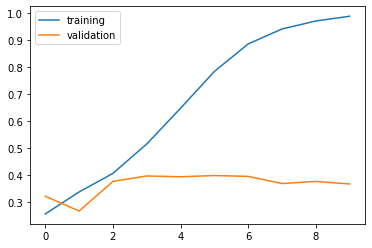

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [28]:
cnn_rand.load_weights('best_model.hdf5')
cnn_rand.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
results = cnn_rand.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

67/67 [==============================] - 0s 5ms/step - loss: 1.3431 - accuracy: 0.4060
Test accuracy:  0.40600094199180603


## CNN-static
- A model with pre-trained vectors from ```word2vec```. All words - including the unknown ones that are randomly initialized- are kept static and only the other parameters of the model are learned

In [29]:
def cnn_static(embed_dim, num_tokens, max_len, windows = [3, 4, 5], filters = 100, p = 0.5, l2 = 3):
    inputs = Input(shape = (max_len, ))
    embedd_intializer = Embedding(input_dim = len(word_idx) + 1, output_dim = embed_dim, \
                         input_length = max_len, weights = [embedding_matrix], trainable = False)
    embedded = embedd_intializer(inputs)

    
    conv_results = []
    for window in windows:
        x = Conv1D(filters, window, activation = 'relu')(embedded)
        x = Dropout(p)(x)
        x = MaxPooling1D(max_len - window + 1)(x)
        conv_results.append(x)
    conv_result = concatenate(conv_results)
    x = GlobalMaxPooling1D()(conv_result)
    x = Dense(50)(x)
    outputs = Dense(5, activation = 'softmax')(x)
    m = Model(inputs = inputs, outputs = outputs)
    m.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
    return m

In [30]:
cnn_static = cnn_static(embed_dim, num_tokens, X_train.shape[1])
callbacks = [ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_acc', verbose=1, save_best_only = True, mode='max')]

In [32]:
history = cnn_static.fit(X_train, y_train, epochs = 10, callbacks = callbacks, validation_split = 0.1, batch_size = 256)

Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.5653 - acc: 0.2889
Epoch 00001: val_acc improved from -inf to 0.33281, saving model to best_model.hdf5
23/23 [==============================] - 3s 135ms/step - loss: 1.5653 - acc: 0.2889 - val_loss: 1.5436 - val_acc: 0.3328
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.5407 - acc: 0.3002
Epoch 00002: val_acc did not improve from 0.33281
23/23 [==============================] - 3s 126ms/step - loss: 1.5407 - acc: 0.3002 - val_loss: 1.5438 - val_acc: 0.3328
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 1.5295 - acc: 0.3150
Epoch 00003: val_acc did not improve from 0.33281
23/23 [==============================] - 3s 128ms/step - loss: 1.5295 - acc: 0.3150 - val_loss: 1.5386 - val_acc: 0.3297
Epoch 4/10
23/23 [==============================] - ETA: 0s - loss: 1.5224 - acc: 0.3231
Epoch 00004: val_acc improved from 0.33281 to 0.33906, saving model to best_model.hdf5
23/23 [===

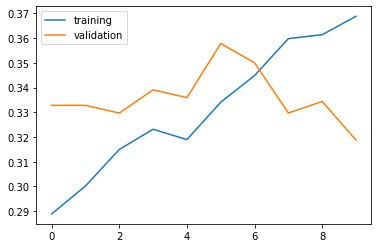

In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [34]:
cnn_static.load_weights('best_model.hdf5')
cnn_static.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
results = cnn_static.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

67/67 [==============================] - 0s 6ms/step - loss: 1.5273 - accuracy: 0.3310
Test accuracy:  0.33098921179771423


## CNN-non-static
- Same as above, but the pretrained vectors are fine-tuned for each task

In [35]:
def cnn_non_static(embed_dim, num_tokens, max_len, windows = [3, 4, 5], filters = 100, p = 0.5, l2 = 3):
    inputs = Input(shape = (max_len, ))
    embedd_intializer = Embedding(input_dim = len(word_idx) + 1, output_dim = embed_dim, \
                     input_length = max_len, weights = [embedding_matrix], trainable = True)
    embedded = embedd_intializer(inputs)
    
    conv_results = []
    for window in windows:
        x = Conv1D(filters, window, activation = 'relu')(embedded)
        x = Dropout(p)(x)
        x = MaxPooling1D(max_len - window + 1)(x)
        conv_results.append(x)
    conv_result = concatenate(conv_results)
    x = GlobalMaxPooling1D()(conv_result)
    x = Dense(50)(x)
    outputs = Dense(5, activation = 'softmax')(x)
    m = Model(inputs = inputs, outputs = outputs)
    m.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
    return m

In [36]:
cnn_non_static = cnn_non_static(embed_dim, num_tokens, X_train.shape[1])
callbacks = [ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_acc', verbose=1, save_best_only = True, mode='max')]

In [37]:
history = cnn_non_static.fit(X_train, y_train, epochs = 10, callbacks = callbacks, validation_split = 0.1, batch_size = 256)

Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.5930 - acc: 0.2627
Epoch 00001: val_acc improved from -inf to 0.31406, saving model to best_model.hdf5
23/23 [==============================] - 4s 173ms/step - loss: 1.5930 - acc: 0.2627 - val_loss: 1.5551 - val_acc: 0.3141
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.5325 - acc: 0.3075
Epoch 00002: val_acc did not improve from 0.31406
23/23 [==============================] - 4s 163ms/step - loss: 1.5325 - acc: 0.3075 - val_loss: 1.5457 - val_acc: 0.2641
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 1.4907 - acc: 0.3431
Epoch 00003: val_acc improved from 0.31406 to 0.35781, saving model to best_model.hdf5
23/23 [==============================] - 4s 163ms/step - loss: 1.4907 - acc: 0.3431 - val_loss: 1.5157 - val_acc: 0.3578
Epoch 4/10
23/23 [==============================] - ETA: 0s - loss: 1.4336 - acc: 0.3935
Epoch 00004: val_acc did not improve from 0.35781
23/23 [===

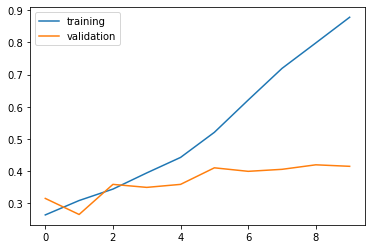

In [38]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [39]:
cnn_non_static.load_weights('best_model.hdf5')
cnn_non_static.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
results = cnn_non_static.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

67/67 [==============================] - 0s 6ms/step - loss: 1.3634 - accuracy: 0.4037
Test accuracy:  0.40365681052207947


## CNN-multichannel
- A model with two sets of word vectors

In [40]:
def cnn_multichannel(embed_dim, num_tokens, max_len, windows = [3, 4, 5], filters = 100, p = 0.5, l2 = 3):
    inputs = Input(shape = (max_len, ))
    embedd_intializer = Embedding(input_dim = len(word_idx) + 1, output_dim = embed_dim, \
                     input_length = max_len, weights = [embedding_matrix], trainable = True)
    embedded_1 = embedd_intializer(inputs)
    
    embedd_intializer = Embedding(input_dim = len(word_idx) + 1, output_dim = embed_dim, \
                     input_length = max_len, weights = [embedding_matrix], trainable = False)
    embedded_2 = embedd_intializer(inputs)
    
    embedded = concatenate([embedded_1, embedded_2])
    
    conv_results = []
    for window in windows:
        x = Conv1D(filters, window, activation = 'relu')(embedded)
        x = Dropout(p)(x)
        x = MaxPooling1D(max_len - window + 1)(x)
        conv_results.append(x)
    conv_result = concatenate(conv_results)
    x = GlobalMaxPooling1D()(conv_result)
    x = Dense(50)(x)
    outputs = Dense(5, activation = 'softmax')(x)
    m = Model(inputs = inputs, outputs = outputs)
    m.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
    return m

In [41]:
cnn_multichannel = cnn_multichannel(embed_dim, num_tokens, X_train.shape[1])
callbacks = [ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_acc', verbose=1, save_best_only = True, mode='max')]

In [42]:
history = cnn_multichannel.fit(X_train, y_train, epochs = 10, callbacks = callbacks, validation_split = 0.1, batch_size = 256)

Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.6136 - acc: 0.2670
Epoch 00001: val_acc improved from -inf to 0.32031, saving model to best_model.hdf5
23/23 [==============================] - 6s 257ms/step - loss: 1.6136 - acc: 0.2670 - val_loss: 1.5382 - val_acc: 0.3203
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.5339 - acc: 0.3181
Epoch 00002: val_acc improved from 0.32031 to 0.34375, saving model to best_model.hdf5
23/23 [==============================] - 6s 251ms/step - loss: 1.5339 - acc: 0.3181 - val_loss: 1.5302 - val_acc: 0.3438
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 1.4832 - acc: 0.3555
Epoch 00003: val_acc improved from 0.34375 to 0.35313, saving model to best_model.hdf5
23/23 [==============================] - 6s 253ms/step - loss: 1.4832 - acc: 0.3555 - val_loss: 1.5024 - val_acc: 0.3531
Epoch 4/10
23/23 [==============================] - ETA: 0s - loss: 1.4312 - acc: 0.3846
Epoch 00004: val_acc im

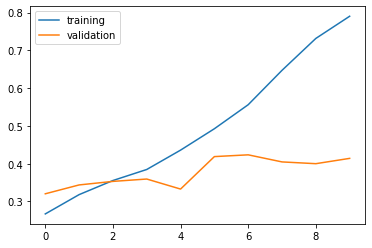

In [43]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [44]:
cnn_multichannel.load_weights('best_model.hdf5')
cnn_multichannel.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
results = cnn_multichannel.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

67/67 [==============================] - 1s 9ms/step - loss: 1.3988 - accuracy: 0.3966
Test accuracy:  0.39662447571754456


## Summary
- All four model variations show high level of training accuracy (almost 1.0), but suffer from low level of validation/test accuracy (below 0.4)
- Summary of evaluation results (test acc)
    - ```CNN-rand```: 0.4060
    - ```CNN-static```: 0.3309
    - ```CNN-non-static```: 0.4036
    - ```CNN-multichannel```: 0.3966